In [140]:
import cv2
import matplotlib.pyplot as plt
from fonctions_image import *

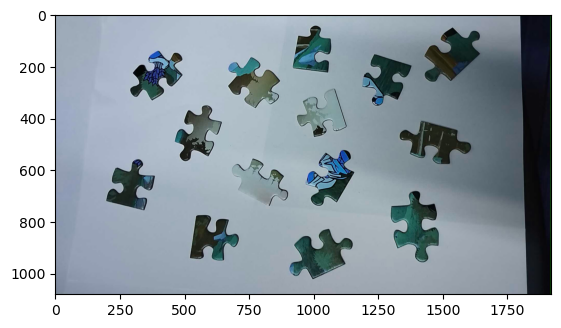

In [141]:
puzzle = cv2.imread('../nos_puzzles/yakari.jpg')
image_test = cv2.imread("../frame.jpg")

plt.imshow(image_test)

Found 13 valid pieces
Piece areas: [20277, 27184, 23759, 22140, 25963, 20977, 24134, 24459, 25249, 21250, 29870, 23519, 27410]

Piece 0:
Position: (894, 21)
Size: (203, 232)
Area: 20277

Piece 1:
Position: (1404, 30)
Size: (262, 258)
Area: 27184

Piece 2:
Position: (268, 118)
Size: (249, 240)
Area: 23759

Piece 3:
Position: (1166, 133)
Size: (239, 249)
Area: 22140

Piece 4:
Position: (644, 148)
Size: (257, 242)
Area: 25963

Piece 5:
Position: (910, 261)
Size: (247, 240)
Area: 20977

Piece 6:
Position: (438, 327)
Size: (237, 269)
Area: 24134

Piece 7:
Position: (1309, 394)
Size: (323, 206)
Area: 24459

Piece 8:
Position: (951, 501)
Size: (234, 265)
Area: 25249

Piece 9:
Position: (173, 533)
Size: (241, 247)
Area: 21250

Piece 10:
Position: (1275, 664)
Size: (238, 321)
Area: 29870

Piece 11:
Position: (497, 749)
Size: (242, 228)
Area: 23519

Piece 12:
Position: (883, 805)
Size: (296, 245)
Area: 27410


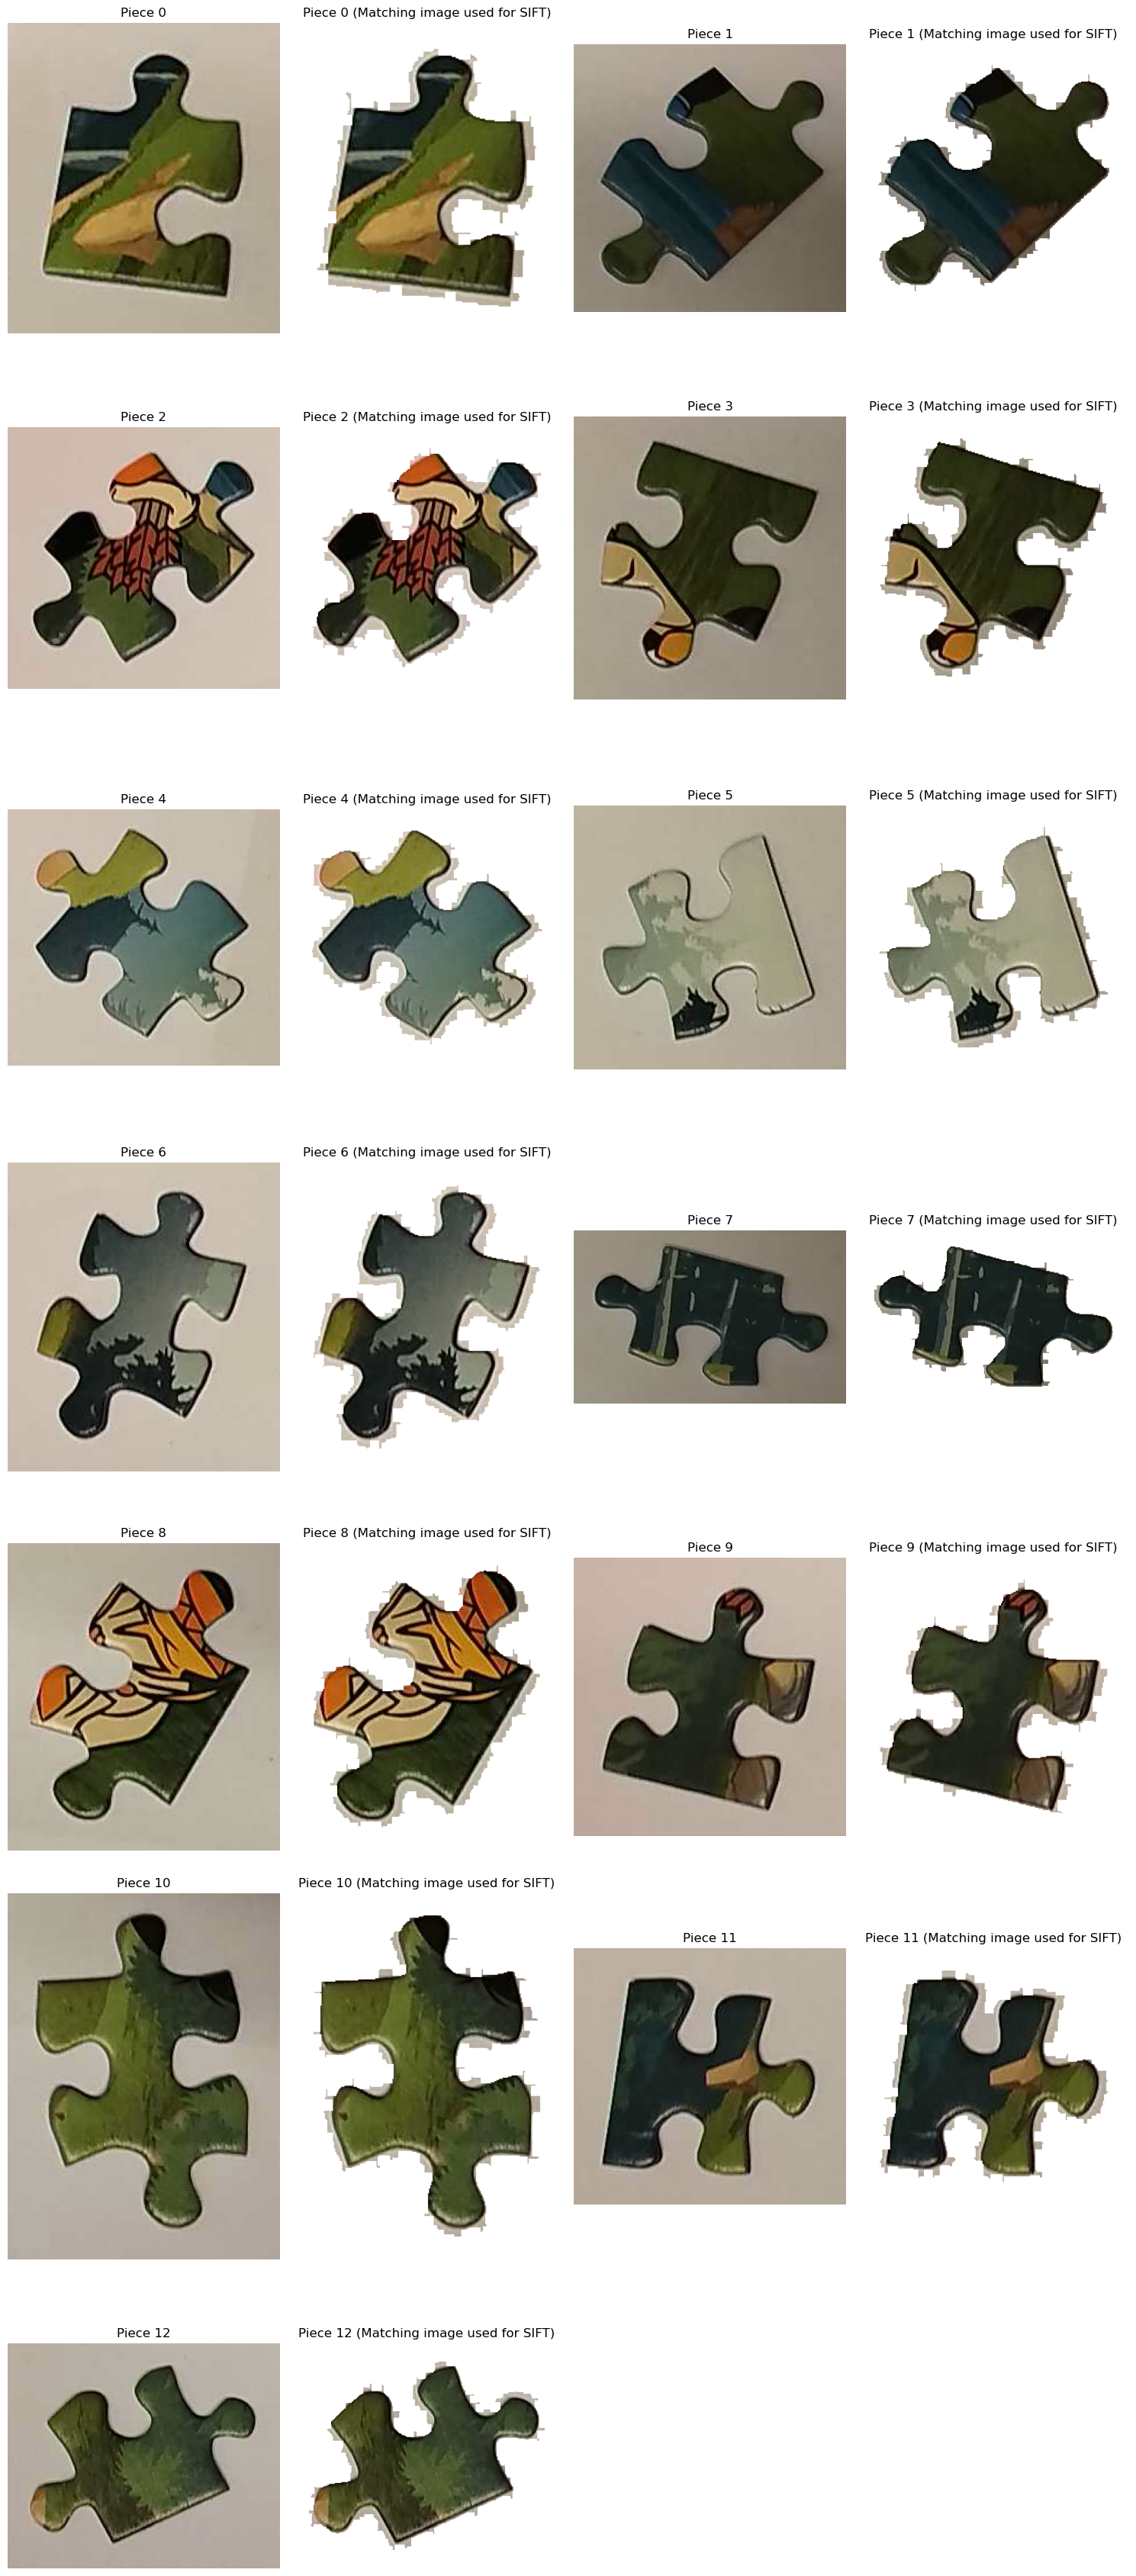

In [142]:
pieces = extract_pieces(image_test)
show_found_pieces(pieces)


### Idée : on réduit le masque pour enlever toutes les features au bord

### AJOUT : filtre feature edges

In [143]:
piece = pieces[8]
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(piece['matching_image'], None)
keypoints_filtered, descriptors_filtered = filter_keypoints_by_mask(keypoints, descriptors, piece['binary_mask'])

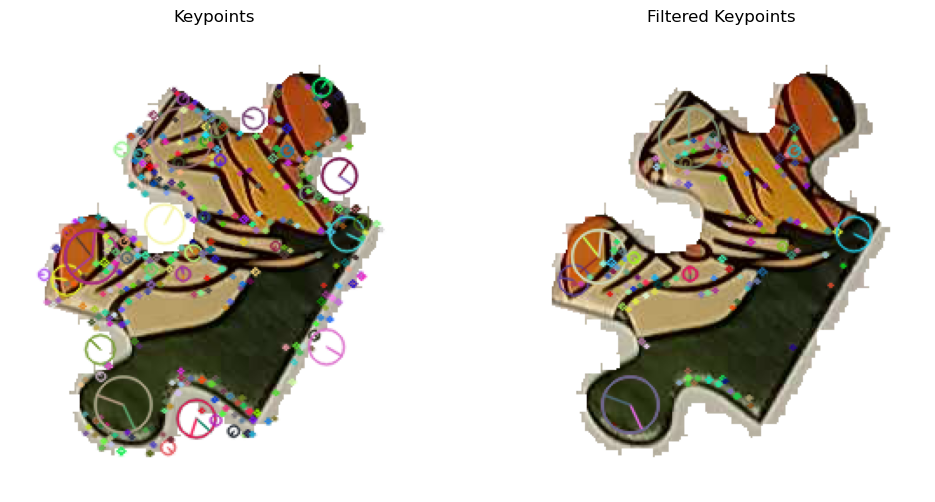

In [144]:
image_with_keypoints = cv2.drawKeypoints(
    piece['matching_image'], keypoints, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Shows size and orientation
)
image_filtered_keypoints = cv2.drawKeypoints(
    piece['matching_image'], keypoints_filtered, None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Shows size and orientation
)

# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Show the original image with keypoints on the first subplot
ax[0].imshow(cv2.cvtColor(image_with_keypoints, cv2.COLOR_BGR2RGB))
ax[0].set_title('Keypoints')
ax[0].axis('off')  # Hide axes

# Show the filtered keypoints image on the second subplot
ax[1].imshow(cv2.cvtColor(image_filtered_keypoints, cv2.COLOR_BGR2RGB))
ax[1].set_title('Filtered Keypoints')
ax[1].axis('off')  # Hide axes

# Display the images
plt.show()


## Fonctions

In [170]:
def calculate_matches(piece, puzzle, keypoints, descriptors, keypoints_full, descriptors_full):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors, descriptors_full, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.85*n.distance:  # Lowe's ratio test (pas sûr de le garder car features peuvent être proches)
            good_matches.append(m)

    good_matches = sorted(good_matches, key=lambda x: x.distance)[:100]
    #La spatial consistency crée un bottleneck majeur
    good_matches = get_spatially_consistent_matches_optimized(good_matches, keypoints_full, piece['size'])

        
    # Draw matches
    match_img = cv2.drawMatches(
        piece['matching_image'], keypoints,
        puzzle, keypoints_full,
        good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
        matchesThickness=3,
        matchColor=(0, 255, 0),
    )
    # Display matches 
    print(f"Found {len(good_matches)} good matches")
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    
    return good_matches


### Sift

In [171]:
def calculate_keypoints_sift(piece, puzzle):
    
    sift = cv2.SIFT_create()
    keypoints_full, descriptors_full = sift.detectAndCompute(puzzle, None)
    
    keypoints, descriptors = sift.detectAndCompute(piece['matching_image'], None)

    keypoints_filtered, descriptors_filtered = filter_keypoints_by_mask(keypoints, descriptors, piece['binary_mask'])
    
    drawn_keypoints = cv2.drawKeypoints(piece["matching_image"], keypoints_filtered, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(drawn_keypoints)
    
    return keypoints_filtered, descriptors_filtered, keypoints_full, descriptors_full
     

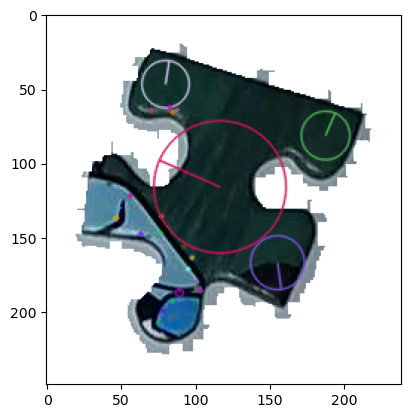

In [182]:
piece = pieces[3]
keypoints_piece, descriptors_piece, keypoints_full, descriptors_full = calculate_keypoints_sift(piece, puzzle)

Found 1 good matches


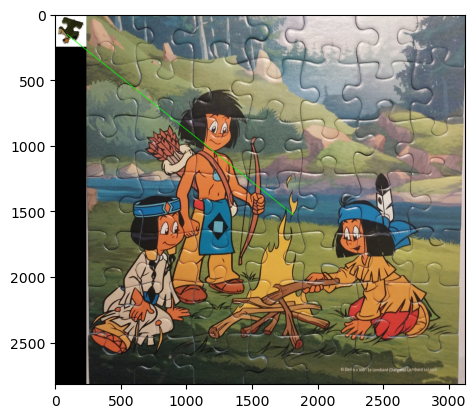

In [183]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece, keypoints_full, descriptors_full)

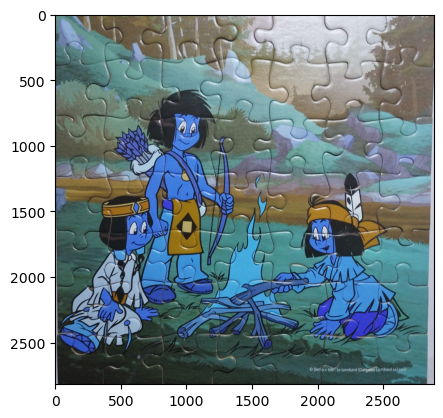

In [184]:
canvas, _ = calculate_transform(piece, matches, keypoints_piece, keypoints_full, puzzle, byhand=True)
plt.imshow(canvas)

### Akaze

In [175]:
def calculate_keypoints_akaze(piece, puzzle) :
    
    akaze = cv2.AKAZE_create()

    keypoints_full, descriptors_full = akaze.detectAndCompute(puzzle, None)
    
    keypoints_piece, descriptors_piece = akaze.detectAndCompute(piece["matching_image"], None)
    
    keypoints_piece, descriptors_piece = filter_keypoints_by_mask(
    keypoints_piece,
    descriptors_piece,
    piece["binary_mask"]
)
    
    drawn_keypoints = cv2.drawKeypoints(piece["matching_image"], keypoints_piece, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(drawn_keypoints)
    
    return keypoints_piece, descriptors_piece, keypoints_full, descriptors_full

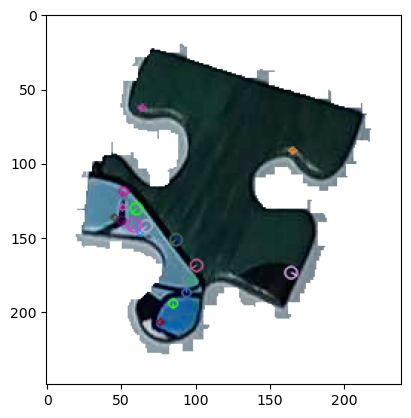

In [179]:
piece = pieces[3]
keypoints_piece, descriptors_piece, keypoints_full, descriptors_full = calculate_keypoints_akaze(piece, puzzle)

Found 1 good matches


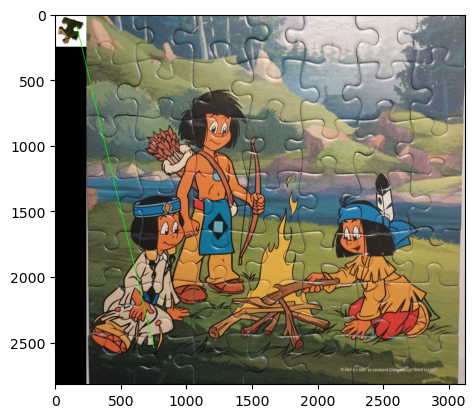

In [180]:
matches = calculate_matches(piece, puzzle, keypoints_piece, descriptors_piece, keypoints_full, descriptors_full)

c:\Users\adrie\OneDrive\Documents\GitHub\INF573_Puzzle\solver_adrien\fonctions_image.py:327: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.sqrt(np.sum(dst_centered**2) / np.sum(src_centered**2))


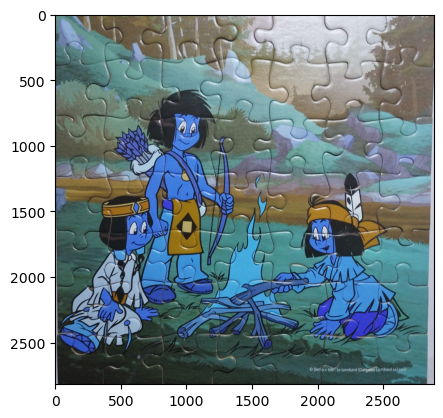

In [181]:
canvas, _ = calculate_transform(piece, matches, keypoints_piece, keypoints_full, puzzle, byhand=True)
plt.imshow(canvas)